# 3) Complete spectrum analysis

In this example, we shall fit all the emission lines on the spectrum of the Green Pea galaxy GP121903 [(see Fernandez et al 2021)](https://arxiv.org/abs/2110.07741) using the ``Spectrum.fit.frame``. This function can fit multiple lines from an input lines frame. Moreover, we are going to show the recommended $LiMe$ workflow: Using external files with the line bands and fitting configuration:

In this exercise, we are going to follow the recommended 

You can download this spectrum from the [examples/sample_data](https://github.com/Vital-Fernandez/lime/tree/master/examples/sample_data). This tutorial can found as a script and a notebook on the [examples folder](https://github.com/Vital-Fernandez/lime/tree/master/examples/tutorials).

## Loading the data

Let's start by importing the script packages and declaring the data location:

In [1]:
import numpy as np
from astropy.io import fits
from IPython.display import Image, display
from pathlib import Path
import lime

In [2]:
# State the input files
obsFitsFile = '../sample_data/spectra/gp121903_osiris.fits'
lineBandsFile = '../sample_data/osiris_bands.txt'
cfgFile = '../sample_data/osiris.toml'

# Spectrum parameters
z_obj = 0.19531
norm_flux = 1e-18

The configuration file (``cfgFile``) can be read with the ``.load_cfg`` function:

In [3]:
# Load configuration
obs_cfg = lime.load_cfg(cfgFile)

# Get object redshfit and normalization flux
z_obj = obs_cfg['sample_data']['z_array'][2]
norm_flux = obs_cfg['sample_data']['norm_flux']

This is a .toml configuration text file which is loaded as a dictionary of dictionaries. 

In [4]:
import pprint
pprint.pprint(obs_cfg)

{'default_line_fitting': {'Ar4_4711A_m': 'Ar4_4711A+He1_4713A',
                          'H1_3889A_m': 'H1_3889A+He1_3889A',
                          'O2_3726A_m': 'O2_3726A+O2_3729A',
                          'O2_7319A_m': 'O2_7319A+O2_7330A'},
 'gp121903_line_fitting': {'H1_6563A_b': 'H1_6563A+N2_6584A+N2_6548A',
                           'N2_6548A_amp': {'expr': 'N2_6584A_amp/2.94'},
                           'N2_6548A_kinem': 'N2_6584A',
                           'O1_6300A_b': 'O1_6300A+S3_6312A',
                           'O3_5007A_b': 'O3_5007A+O3_5007A_k-1',
                           'O3_5007A_k-1_amp': {'expr': '<100.0*O3_5007A_amp',
                                                'min': 0.0},
                           'O3_5007A_k-1_sigma': {'expr': '>2.0*O3_5007A_sigma'},
                           'S2_6716A_b': 'S2_6716A+S2_6731A',
                           'S2_6731A_kinem': 'S2_6716A'},
 'sample_data': {'files_list': ['gp030321_BR.fits',
                           

You can read more about how to use these files on the [fitting configuration documentation](https://lime-stable.readthedocs.io/en/latest/inputs/n_inputs4_fit_configuration.html)

You can load the bands file from the [second tutorial](https://lime-stable.readthedocs.io/en/latest/tutorials/n_tutorial2_lines_inspection.html) as a [pandas dataframe](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) using the ``load_frame`` function:

In [5]:
# Load line bands
bands = lime.load_frame(lineBandsFile)

In the [first tutorial](https://lime-stable.readthedocs.io/en/latest/tutorials/n_tutorial1_single_line_fit.html), we opened the observation using the [standard aproach with astropy](https://lime-stable.readthedocs.io/en/latest/inputs/n_inputs1_spectra.html). This time we are going to use $LiMe$ functions to read a *.fits* file:

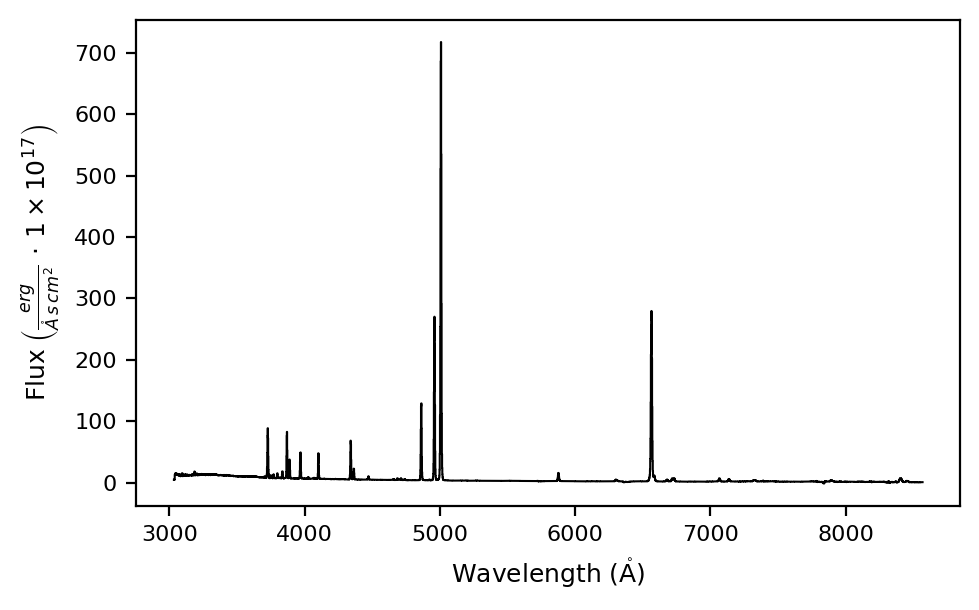

In [6]:
gp_spec = lime.Spectrum.from_file(obsFitsFile, instrument='osiris', redshift=z_obj, norm_flux=norm_flux)
gp_spec.plot.spectrum(rest_frame=True)

## Line detection

In the previous tutorial, we manually selected the bands, so we are certain that all the lines are present. However in large datasets it may not be possible to inspect all the lines manually. You can use $LiMe$ functions to help you with this task.

The current method available is based on an [intensity threshold](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2631518/) for the emission or absorption lines. To improve the performance fo this task, the first step consists in adjusting the observation continuum:

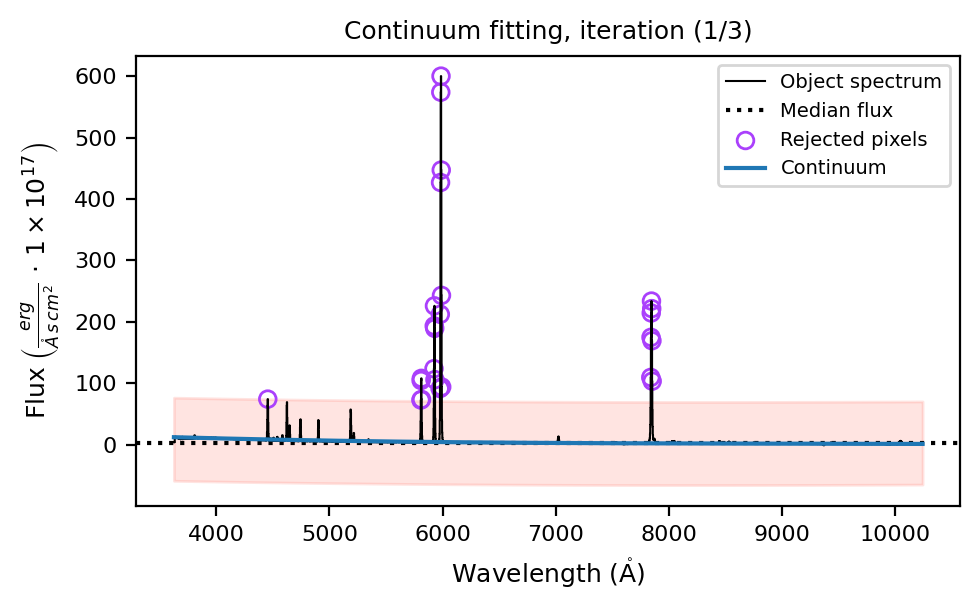

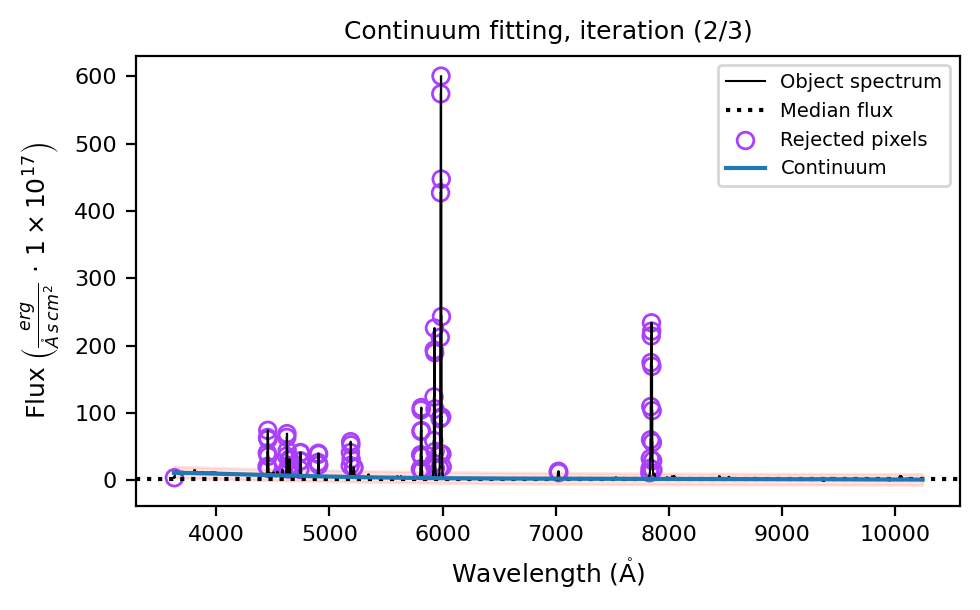

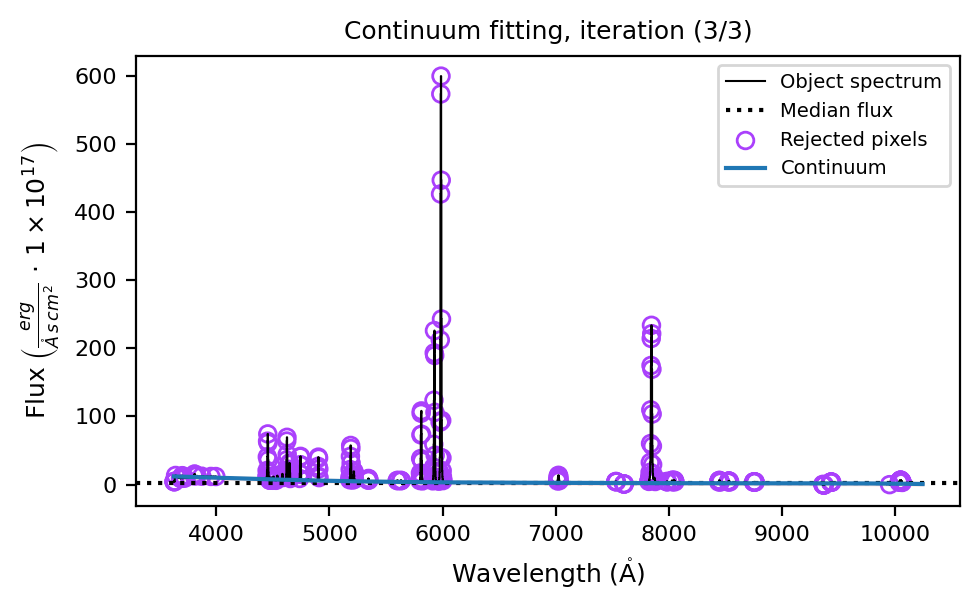

In [7]:
gp_spec.fit.continuum(degree_list=[3, 6, 6], emis_threshold=[3, 2, 1.5], plot_steps=True)

The task ``Spectrum.fit.continuum`` provides an interactive analysis: The user introduces a list of degrees for the polynomial degrees and a multiplicative factor in the ``degree_list`` and ``emis_threshold``, respectively. At each step, the algorihm fits a polinomial of the given order, rejecting the points which are above/below the multiplicative factor of the standard deviation of the residual betwen the observed spectrum and the fit continuum. The fitting excludes all the points which were rejected from the previous iterations. If the user does not include an ``abs_threshold`` array, the algorithm uses the multiplicative factor from the ``emis_threshold``.

Once we have computed the continuum we can use the ``Spectrum.line_detection`` function to detect peaks or trough and compare them against the theoretical line locations:

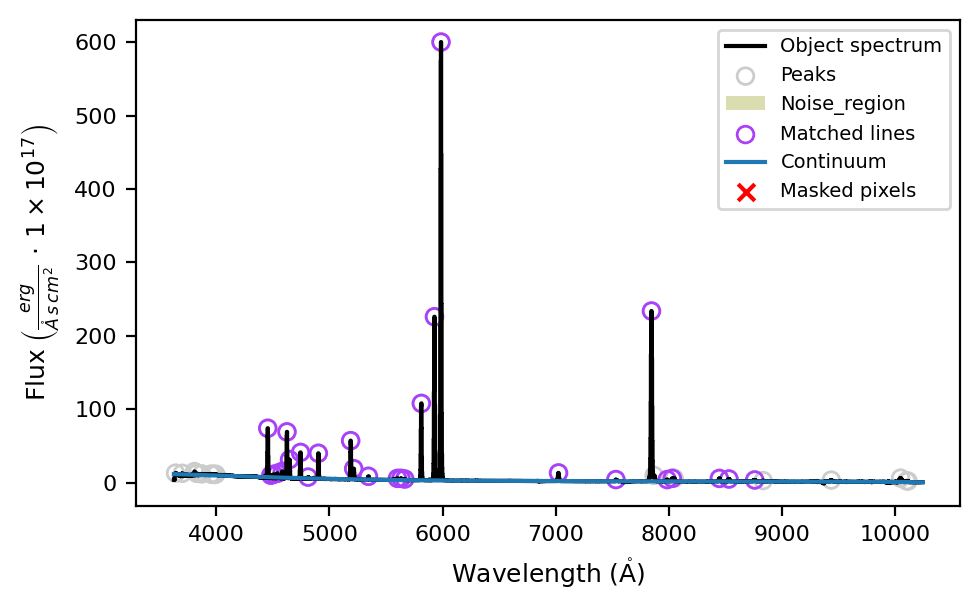

In [8]:
# Find the lines
matched_bands = gp_spec.line_detection(lineBandsFile, sigma_threshold=3, plot_steps=True)

In this function, the ``sigma_threshold`` argument states the factor above the continuum sigma flux threshold for a line detection. The argument ``emis_type=True`` for emission lines and ``emis_type=False`` for absorption lines. 

The user needs to include a bands dataframe, such as the ``lineBandsFile`` we computed from the previous tutorial.

You can plot a set of bands in you spectrum with the ``line_bands`` argument in the ``.plot.spectrum`` function:

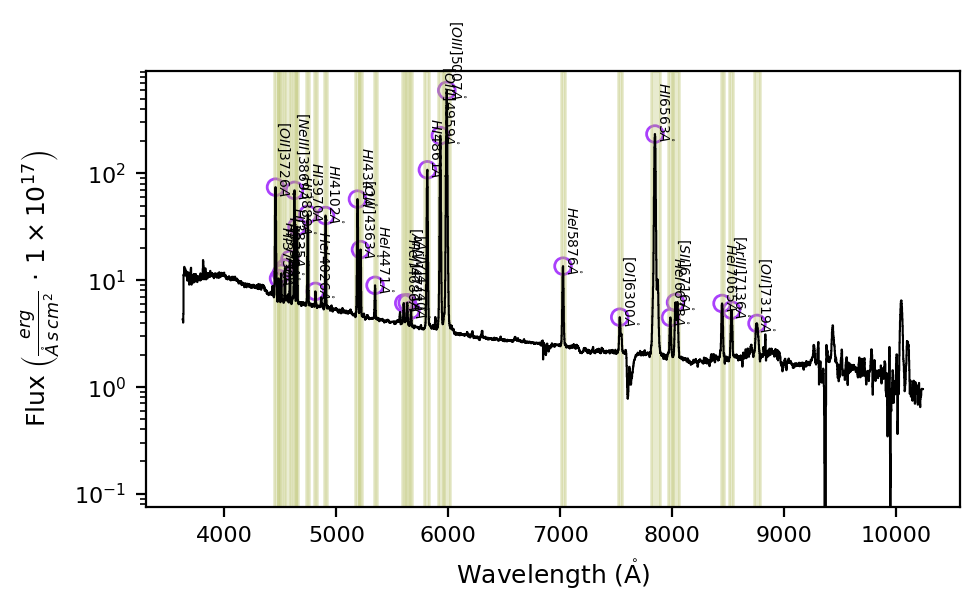

In [9]:
gp_spec.plot.spectrum(label='GP121903 matched lines', line_bands=matched_bands, log_scale=True)

## Line measurement

Now we are going to measure all the lines in this bands dataframe using the ``Spectrum.fit.frame`` function. This function will read the ``obj_bands_file`` and proceed to fit all the lines taking into consideration the lines fitting configuration from the ``obs_cfg`` dictionary.

In [10]:
gp_spec.fit.frame(bands=matched_bands, fit_conf=obs_cfg, id_conf_prefix='gp121903')


Line fitting progress:
[==========] 100% of 27 lines (O2_7319A_m)

<div class="alert alert-info">

**Please remember:** You can introduce the line ``bands`` and fitting configuration ``fit_conf`` file addresses and the ``.fit.`` functions will read them for you.
</div>

The ``Spectrum.fit.frame`` function allows the user to combine a "default" fitting configuration with an "individual" fitting configuration. The former configuration parameters are specified with ``default_conf_prefix`` argument, while the latter uses the ``id_conf_prefix``. For example, in the previous fitting, we had the "default_line_fitting" and the "gp121903_line_fitting" form the configuration file:

In [11]:
print(f'# Default line fitting')
pprint.pprint(obs_cfg['default_line_fitting'])

print(f'\n# Individual line fitting')
pprint.pprint(obs_cfg['gp121903_line_fitting'])

# Default line fitting
{'Ar4_4711A_m': 'Ar4_4711A+He1_4713A',
 'H1_3889A_m': 'H1_3889A+He1_3889A',
 'O2_3726A_m': 'O2_3726A+O2_3729A',
 'O2_7319A_m': 'O2_7319A+O2_7330A'}

# Individual line fitting
{'H1_6563A_b': 'H1_6563A+N2_6584A+N2_6548A',
 'N2_6548A_amp': {'expr': 'N2_6584A_amp/2.94'},
 'N2_6548A_kinem': 'N2_6584A',
 'O1_6300A_b': 'O1_6300A+S3_6312A',
 'O3_5007A_b': 'O3_5007A+O3_5007A_k-1',
 'O3_5007A_k-1_amp': {'expr': '<100.0*O3_5007A_amp', 'min': 0.0},
 'O3_5007A_k-1_sigma': {'expr': '>2.0*O3_5007A_sigma'},
 'S2_6716A_b': 'S2_6716A+S2_6731A',
 'S2_6731A_kinem': 'S2_6716A'}


<div class="alert alert-info">

**Please remember:** The ``Spectrum.fit.frame`` function **updates** the default parameters with the new ones. This means that only the common entries in the default configurations are replaced. Consequently, in the fittings of GP121903 the configuration used would be:

</div>

In [12]:
pprint.pprint({**obs_cfg['default_line_fitting'], **obs_cfg['gp121903_line_fitting']})

{'Ar4_4711A_m': 'Ar4_4711A+He1_4713A',
 'H1_3889A_m': 'H1_3889A+He1_3889A',
 'H1_6563A_b': 'H1_6563A+N2_6584A+N2_6548A',
 'N2_6548A_amp': {'expr': 'N2_6584A_amp/2.94'},
 'N2_6548A_kinem': 'N2_6584A',
 'O1_6300A_b': 'O1_6300A+S3_6312A',
 'O2_3726A_m': 'O2_3726A+O2_3729A',
 'O2_7319A_m': 'O2_7319A+O2_7330A',
 'O3_5007A_b': 'O3_5007A+O3_5007A_k-1',
 'O3_5007A_k-1_amp': {'expr': '<100.0*O3_5007A_amp', 'min': 0.0},
 'O3_5007A_k-1_sigma': {'expr': '>2.0*O3_5007A_sigma'},
 'S2_6716A_b': 'S2_6716A+S2_6731A',
 'S2_6731A_kinem': 'S2_6716A'}


## Plotting and saving the measurements

The fitted profiles can be over-plotted on the input spectrum setting the ``include_fits=True`` parameter on the ``Spectrum.plot.spectrum`` function

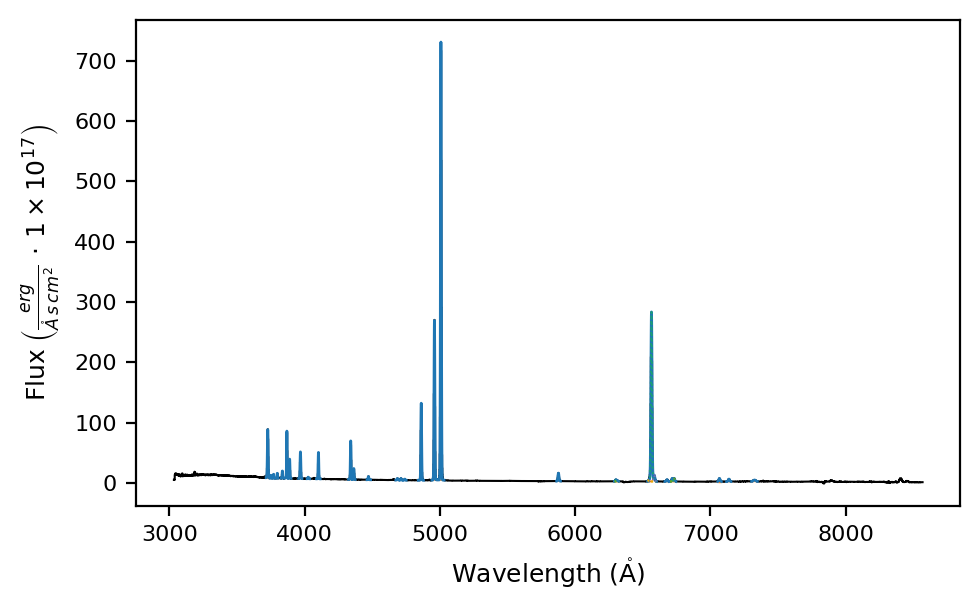

In [13]:
# Display the fits on the spectrum
gp_spec.plot.spectrum(include_fits=True, rest_frame=True)

Additionally, you can also plot the results as a grid using the ``Spectrum.plot.grid``

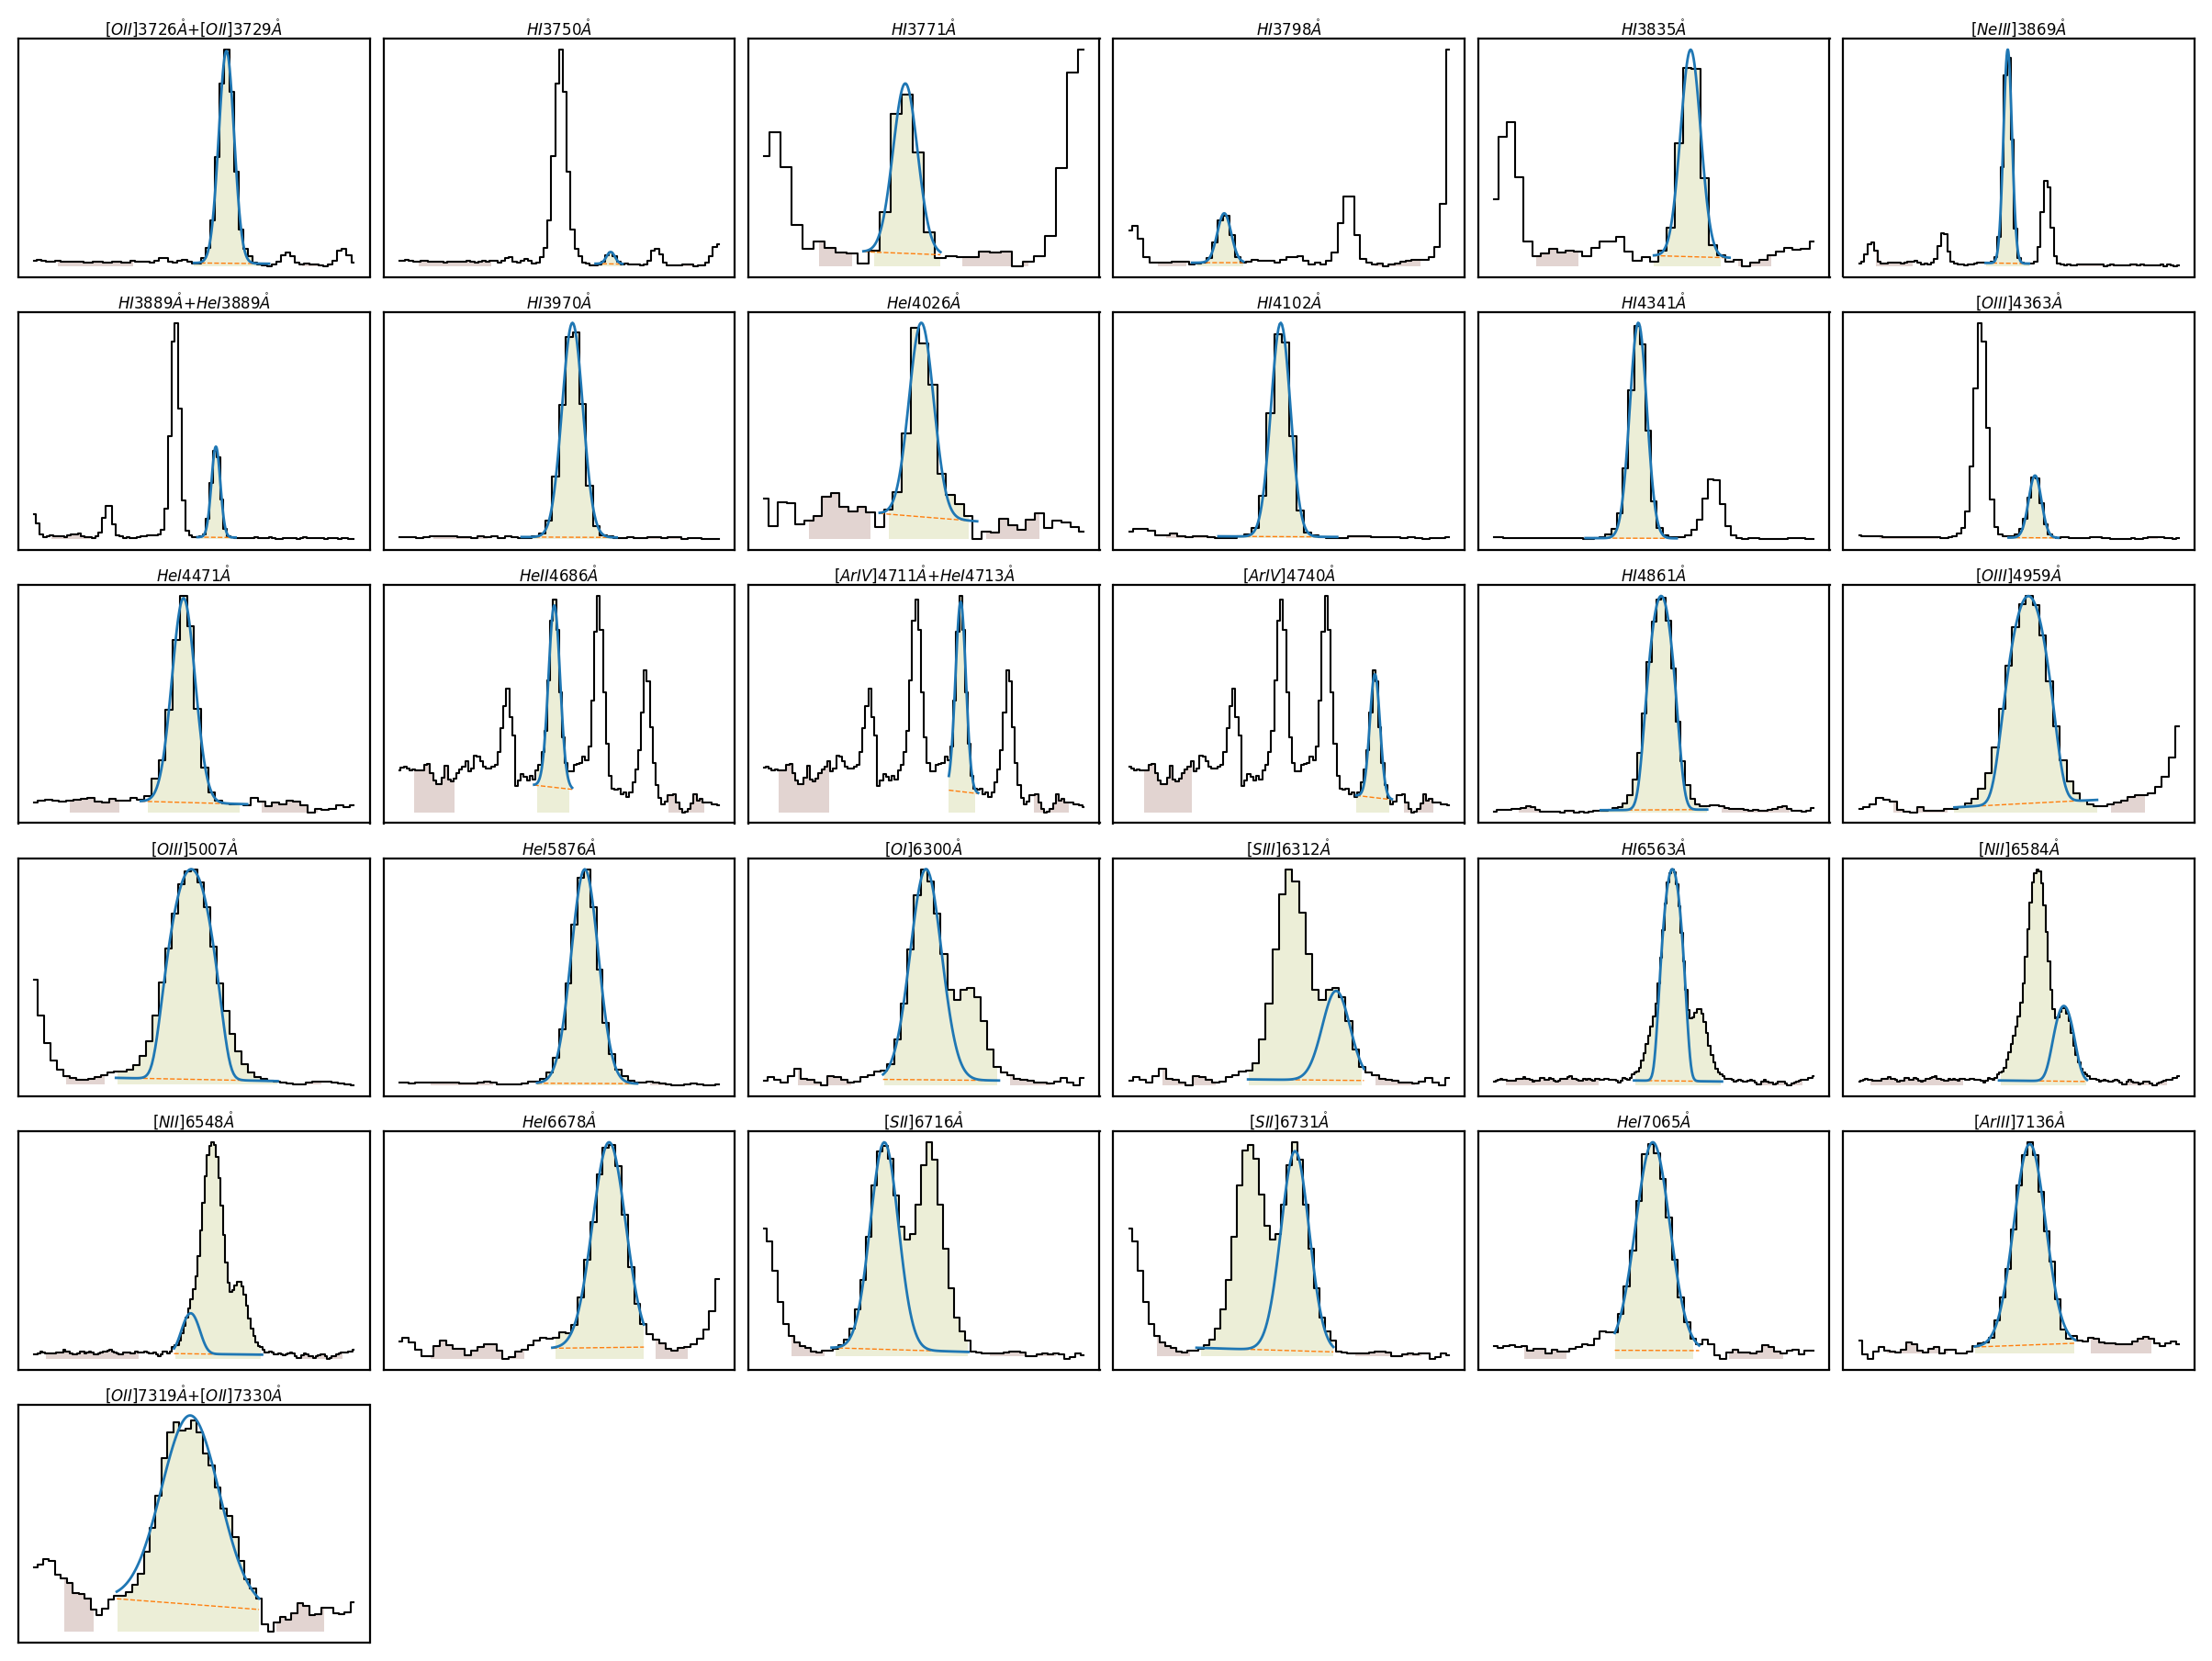

In [14]:
# Display a grid with the fits
gp_spec.plot.grid()

You can plot individual line fittings with the ``Spectrum.plot.band`` function:

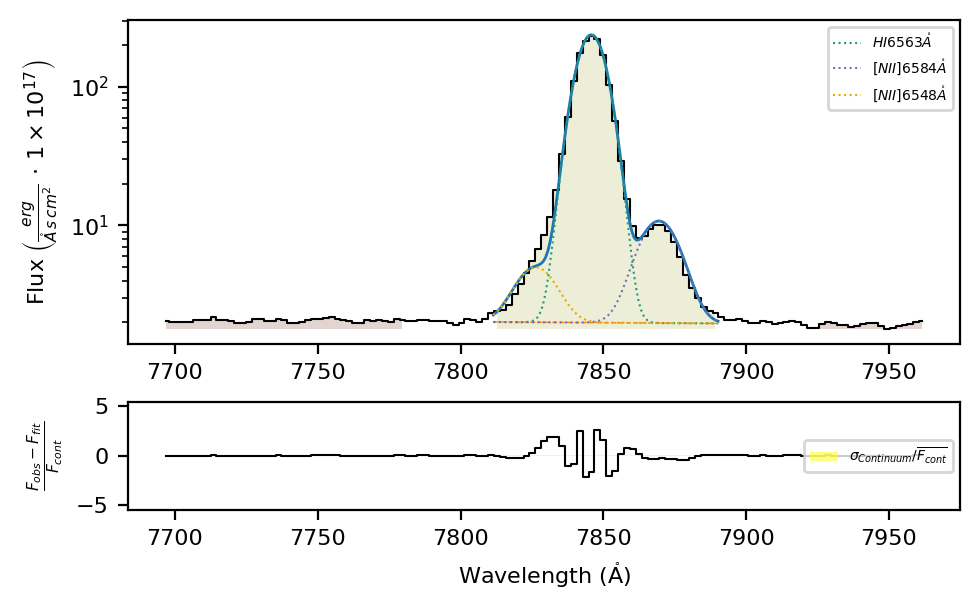

In [15]:
gp_spec.plot.bands('H1_6563A')

Finally, we save the tabulated measurements with:

In [16]:
# Save the data
gp_spec.save_frame('../sample_data/example3_linelog.fits', page='GP121903_a')

or

In [17]:
lime.save_frame('../sample_data/example3_linelog.fits', gp_spec.frame,  page='GP121903b')